# CMB-S4 All Chile config - Neff plots

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np, glob, healpy as H, os, sys, pickle, tools
from pylab import *

import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger().setLevel(logging.ERROR)

In [3]:
rcParams['figure.dpi'] = 150
rcParams['figure.facecolor'] = 'white'
rcParams['font.family'] = 'serif'

# Read the Fisher matrices

In [6]:
survey_dic = {
             'wide': ['wide_supplement', r'LAT-Wide'],
             'roman': ['roman_supplement', r'LAT-Roman'], 
             'delensing': ['delensing_sun90bk', r'LAT-Delensing'], 
             'dc0': ['DC0', r'LAT-DC0'], 
             }

expname_pref = 's4_all_chile_config'
survey_arr = ['wide', 'delensing']
patch_arr = [1, 2, 3, 4]
year_arr = np.arange(1, 10.1)


fsky_dic = {'GAL070':
                {
                    'wide': {1: 0.053918, 2: 0.217058, 3: 0.0122569, 4: 0.0207677}, 
                    'dc0': {1: 0.475881}, 
                    'delensing': {1: 0.043, 2: 0.021, 3: 0.010, 4: 0.015},
                },
            'GAL080':
                {
                    'wide': {1: 0.0592472, 2: 0.257352, 3: 0.0139942, 4: 0.0238788}, 
                    'dc0': {1: 0.53747}, 
                    'delensing': {1: 0.043, 2: 0.021, 3: 0.010, 4: 0.015},
                },
            'GAL090':
                {
                    'wide': {1: 0.064, 2: 0.31, 3: 0.016, 4: 0.027}, 
                    'dc0': {1: 0.598036}, 
                    'delensing': {1: 0.043, 2: 0.021, 3: 0.010, 4: 0.015},
                }
           }

dc0_fsky_dic = {'GAL070':
                {
                    'wide': {1: 0.475881}, 
                },
            'GAL080':
                {
                    'wide': {1: 0.53747}, 
                },
            'GAL090':
                {
                    'wide': {1: 0.598036}, 
                }
           }
fsky_dic_aso = {'aso_only': 
                   {
                    'baseline': 0.4, 
                    'goal': 0.4,
                   },
                'aso_plus_s4': 
                   {
                    'baseline': 0.12, 
                    'goal': 0.12,
                   }
               }
aso_dc0_res_dic = fsky_dic_aso

fd = 'results/neff/phase3/'
fname = '%s/saveChileS4Fishers_fsky1.pkl' %(fd)
res_dic = pickle.load( open(fname, 'rb') )
print( res_dic.keys() )

#dc0 results
fd = 'results/neff/phase2_and_DC0/'
fname = '%s/saveChileS4Fishers_DC0_fsky1.pkl' %(fd)
dc0_res_dic = pickle.load( open(fname, 'rb') )
print( dc0_res_dic.keys() )

aso_fd = 'results/neff/phase3_SO/'
aso_exp_dic = {'baseline': ['ASO-Baseline', 'royalblue'], 
               'goal': ['ASO-Goal', 'darkorange']}
aso_fname = '%s/saveChileSOFishers_fsky100_lensed.pkl' %(aso_fd)
aso_res_dic = pickle.load( open(aso_fname, 'rb') )
aso_patch = 1
aso_year = 1
print( aso_res_dic.keys() )

#params
param_names = ['omega_c_h2', 'omega_b_h2', 'N_eff', 'A_s', 'n_s', 'tau', 'theta_s']
desired_param = 'N_eff'


dict_keys(['wide', 'delensing', 'S4'])
dict_keys(['wide'])
dict_keys(['baseline', 'goal', 'S4'])


# Neff for GAL070, GAL080, and GAL090 mask
* ## Patch 1 and 2, and 
* ## all patches combined

In [7]:
reqd_gal_mask_arr = ['GAL070', 'GAL080', 'GAL090']
sigma_neff_dic = {}
sigma_neff_dic_for_aso = {}
sigma_neff_dic_for_s4_plus_aso = {}
for reqd_gal_mask in reqd_gal_mask_arr:
    sigma_neff_dic[reqd_gal_mask] = {}
    sigma_neff_dic_for_s4_plus_aso[reqd_gal_mask] = {}
    for iter in range(2):
        sigma_neff_dic[reqd_gal_mask][iter] = {}
        sigma_neff_dic_for_s4_plus_aso[reqd_gal_mask][iter] = {}
        if iter == 0:
            reqd_patch_arr = [1, 2]
        else:
            reqd_patch_arr = [1, 2, 3, 4]
        fisher_dic = {}
        for survey in res_dic:
            if survey == 'S4': continue
            #print(res_dic[keyname].keys()); sys.exit()
            fisher_dic[survey] = {}
            for patch in patch_arr:
                if patch not in reqd_patch_arr: continue
                fisher_dic[survey][patch] = {}
                for year in year_arr:
                    fmat = res_dic[survey][patch][year]

                    #multiply fmat with fsky
                    curr_fsky = fsky_dic[reqd_gal_mask][survey][patch]
                    fmat = fmat * curr_fsky
                    ##print(reqd_gal_mask, iter, survey, patch, curr_fsky, fmat.shape)
                    fisher_dic[survey][patch][year] = fmat
                    
        #ASO results
        aso_fisher_dic = {}
        for aso_iter in range(2):
            aso_fisher_dic[aso_iter] = {}
            for survey in aso_res_dic:
                if survey == 'S4': continue
                aso_fisher_dic[survey] = {}
                fmat = aso_res_dic[survey][aso_patch][aso_year]

                #multiply fmat with fsky
                if aso_iter == 0:
                    curr_fsky = fsky_dic_aso['aso_only'][survey]
                elif aso_iter == 1:
                    curr_fsky = fsky_dic_aso['aso_plus_s4'][survey]
                fmat = fmat * curr_fsky
                aso_fisher_dic[aso_iter][survey] = fmat

        #------------------------------------------
        #combine Fisher matrices now

        #S4-only
        ##print('\n\ncombine Fisher matrices now\n')
        survey1, survey2 = 'wide', 'delensing'
        survey_arr_for_comb = [survey1, survey2]
        for year in year_arr:
            comb_fmat = None
            for survey in survey_arr_for_comb:
                #print(survey)
                for patch in fisher_dic[survey]:
                    #print(patch)
                    curr_fmat = fisher_dic[survey][patch][year]
                    if comb_fmat is None:
                        comb_fmat = np.copy( curr_fmat )
                    else:
                        comb_fmat += np.copy( curr_fmat )


            #get neff sigma
            curr_sigma_neff = tools.get_sigma_of_a_parameter(comb_fmat, param_names, [desired_param])
            sigma_neff_dic[reqd_gal_mask][iter][year] = curr_sigma_neff[desired_param]

        #ASO-only
        aso_expname_arr = ['baseline', 'goal']
        aso_iter = 0
        for aso_expname in aso_expname_arr:
            aso_fmat = aso_fisher_dic[aso_iter][aso_expname]
            #get neff sigma
            curr_sigma_neff = tools.get_sigma_of_a_parameter(aso_fmat, param_names, [desired_param])
            sigma_neff_dic_for_aso[aso_expname] = curr_sigma_neff[desired_param]
        
        #S4+ASO
        survey1, survey2 = 'wide', 'delensing'
        survey_arr_for_comb = [survey1, survey2]
        aso_expname_arr = ['baseline', 'goal']
        aso_iter = 1
        for aso_expname in aso_expname_arr:
            sigma_neff_dic_for_s4_plus_aso[reqd_gal_mask][iter][aso_expname] = {}
            for year in year_arr:
                comb_fmat = None
                for survey in survey_arr_for_comb:
                    #print(survey)
                    for patch in fisher_dic[survey]:
                        #print(patch)
                        curr_fmat = fisher_dic[survey][patch][year]
                        if comb_fmat is None:
                            comb_fmat = np.copy( curr_fmat )
                        else:
                            comb_fmat += np.copy( curr_fmat )
            
                #now add ASO's Fmat
                aso_fmat = aso_fisher_dic[aso_iter][aso_expname]
                comb_fmat += aso_fmat

                #get neff sigma
                curr_sigma_neff = tools.get_sigma_of_a_parameter(comb_fmat, param_names, [desired_param])
                sigma_neff_dic_for_s4_plus_aso[reqd_gal_mask][iter][aso_expname][year] = curr_sigma_neff[desired_param]        
        #------------------------------------------


# DC0 now

In [8]:
reqd_gal_mask_arr = ['GAL070', 'GAL080', 'GAL090']
dc0_sigma_neff_dic = {}
dc0_sigma_neff_dic_for_aso = {}
dc0_sigma_neff_dic_for_s4_plus_aso = {}
for reqd_gal_mask in reqd_gal_mask_arr:
    dc0_sigma_neff_dic[reqd_gal_mask] = {}
    dc0_sigma_neff_dic_for_s4_plus_aso[reqd_gal_mask] = {}
    for iter in range(1):
        dc0_sigma_neff_dic[reqd_gal_mask][iter] = {}
        dc0_sigma_neff_dic_for_s4_plus_aso[reqd_gal_mask][iter] = {}
        if iter == 0:
            reqd_patch_arr = [1]
        else:
            reqd_patch_arr = [1, 2]
        fisher_dic = {}
        for survey in dc0_res_dic:
            if survey == 'S4': continue
            #print(dc0_res_dic[keyname].keys()); sys.exit()
            fisher_dic[survey] = {}
            for patch in patch_arr:
                if patch not in reqd_patch_arr: continue
                fisher_dic[survey][patch] = {}
                for year in year_arr:
                    fmat = dc0_res_dic[survey][patch][year]

                    #multiply fmat with fsky
                    curr_fsky = dc0_fsky_dic[reqd_gal_mask][survey][patch]
                    #print(survey, reqd_gal_mask, patch)
                    #print(curr_fsky); sys.exit()
                    fmat = fmat * curr_fsky
                    ##print(reqd_gal_mask, iter, survey, patch, curr_fsky, fmat.shape)
                    fisher_dic[survey][patch][year] = fmat
                    
        #ASO results
        aso_fisher_dic = {}
        for aso_iter in range(2):
            aso_fisher_dic[aso_iter] = {}
            for survey in aso_res_dic:
                if survey == 'S4': continue
                aso_fisher_dic[survey] = {}
                fmat = aso_res_dic[survey][aso_patch][aso_year]

                #multiply fmat with fsky
                if aso_iter == 0:
                    curr_fsky = fsky_dic_aso['aso_only'][survey]
                elif aso_iter == 1:
                    curr_fsky = fsky_dic_aso['aso_plus_s4'][survey]
                fmat = fmat * curr_fsky
                aso_fisher_dic[aso_iter][survey] = fmat

        #------------------------------------------
        #combine Fisher matrices now

        #S4-only
        ##print('\n\ncombine Fisher matrices now\n')
        survey1 = 'wide'
        survey_arr_for_comb = [survey1]
        for year in year_arr:
            comb_fmat = None
            for survey in survey_arr_for_comb:
                #print(survey)
                for patch in fisher_dic[survey]:
                    #print(patch)
                    curr_fmat = fisher_dic[survey][patch][year]
                    if comb_fmat is None:
                        comb_fmat = np.copy( curr_fmat )
                    else:
                        comb_fmat += np.copy( curr_fmat )


            #get neff sigma
            curr_dc0_sigma_neff = tools.get_sigma_of_a_parameter(comb_fmat, param_names, [desired_param])
            dc0_sigma_neff_dic[reqd_gal_mask][iter][year] = curr_dc0_sigma_neff[desired_param]

        #ASO-only
        aso_expname_arr = ['baseline', 'goal']
        aso_iter = 0
        for aso_expname in aso_expname_arr:
            aso_fmat = aso_fisher_dic[aso_iter][aso_expname]
            #get neff sigma
            curr_dc0_sigma_neff = tools.get_sigma_of_a_parameter(aso_fmat, param_names, [desired_param])
            dc0_sigma_neff_dic_for_aso[aso_expname] = curr_dc0_sigma_neff[desired_param]
        
        #S4+ASO
        #survey1, survey2 = 'wide'#, 'delensing'
        survey1 = 'wide'#, 'delensing'
        survey_arr_for_comb = [survey1]#, survey2]
        aso_expname_arr = ['baseline', 'goal']
        aso_iter = 1
        for aso_expname in aso_expname_arr:
            dc0_sigma_neff_dic_for_s4_plus_aso[reqd_gal_mask][iter][aso_expname] = {}
            for year in year_arr:
                comb_fmat = None
                for survey in survey_arr_for_comb:
                    #print(survey)
                    for patch in fisher_dic[survey]:
                        #print(patch)
                        curr_fmat = fisher_dic[survey][patch][year]
                        if comb_fmat is None:
                            comb_fmat = np.copy( curr_fmat )
                        else:
                            comb_fmat += np.copy( curr_fmat )
            
                #now add ASO's Fmat
                aso_fmat = aso_fisher_dic[aso_iter][aso_expname]
                comb_fmat += aso_fmat

                #get neff sigma
                curr_dc0_sigma_neff = tools.get_sigma_of_a_parameter(comb_fmat, param_names, [desired_param])
                dc0_sigma_neff_dic_for_s4_plus_aso[reqd_gal_mask][iter][aso_expname][year] = curr_dc0_sigma_neff[desired_param]        
        #------------------------------------------


# DCO+ASO at the maplevel; SPT-3G+ in the delensing patch.

In [43]:
#ASO at maplevel
aso_baseline_maplevel_comb_fname = 'results/neff/saveChileS4Fishers_DC0_SO-B_fsky1.pkl'
aso_goal_maplevel_comb_fname = 'results/neff/saveChileS4Fishers_DC0_SO-G_fsky1.pkl'
aso_baseline_maplevel_comb_dic = pickle.load( open(aso_baseline_maplevel_comb_fname, 'rb') )
aso_goal_maplevel_comb_dic = pickle.load( open(aso_goal_maplevel_comb_fname, 'rb') )


#SPT-3G+
spt3gplus_fname = 'results/neff/saveChileSPT3GPlusFishers_fsky1_delensed.pkl'
spt3gplus_dic = pickle.load( open(spt3gplus_fname, 'rb') )
#print(spt3gplus_dic)

#SPT-3G+
fsky_spt3g_plus = 1500./41253.
fmat_spt3g_plus = spt3gplus_dic['baseline'][1][1]
#sigma_neff_spt3gplus = tools.get_sigma_of_a_parameter(fmat_spt3g_plus * fsky_spt3g_plus, param_names, [desired_param])
#print(sigma_neff_spt3gplus)

dc0_gal = 'GAL090'
dc0_survey = 'wide'
dc0_patch = 1
dc0_year_arr = [1, 5]
dc0_fsky = dc0_fsky_dic[dc0_gal][dc0_survey][dc0_patch]
dc0_fsky_minus_spt3g_plus = dc0_fsky - fsky_spt3g_plus
print(fsky)
aso_map_level_comb_sigma_neff_dic = {}
for aso_map_level_comb_iter in range(4):
    for dc0_year in dc0_year_arr:
        if aso_map_level_comb_iter == 0:
            curr_fmat = dc0_res_dic[dc0_survey][dc0_patch][dc0_year]
            labval = r'DC0'
            curr_fmat = curr_fmat * dc0_fsky
        elif aso_map_level_comb_iter == 1:
            curr_fmat = aso_baseline_maplevel_comb_dic[dc0_survey][dc0_patch][dc0_year]
            labval = r'DC0 + SO-Baseline'
            curr_fmat = curr_fmat * dc0_fsky
        elif aso_map_level_comb_iter == 2:
            curr_fmat = aso_goal_maplevel_comb_dic[dc0_survey][dc0_patch][dc0_year]
            labval = r'DC0 + SO-Goal'
            curr_fmat = curr_fmat * dc0_fsky
        elif aso_map_level_comb_iter == 3:
            labval = r'DC0 + SO-Goal + SPT-3G+'
            curr_fmat1 = aso_goal_maplevel_comb_dic[dc0_survey][dc0_patch][dc0_year]
            curr_fmat1 = curr_fmat1 * dc0_fsky_minus_spt3g_plus
            curr_fmat2 = aso_goal_maplevel_comb_dic[dc0_survey][dc0_patch][dc0_year]
            curr_fmat2 = curr_fmat2 * fsky_spt3g_plus
            curr_fmat = curr_fmat1 + curr_fmat2
            
        
        curr_dc0_sigma_neff = tools.get_sigma_of_a_parameter(curr_fmat, param_names, [desired_param])
        aso_map_level_comb_sigma_neff_dic[labval] = curr_dc0_sigma_neff
        

        print( 'Survey: %s; year = %s; \sigma(neff) = %s' %(labval, dc0_year, curr_dc0_sigma_neff) )
    print('\n')

    


0.598036
Survey: DC0; year = 1; \sigma(neff) = {'N_eff': 0.038400297495463066}
Survey: DC0; year = 5; \sigma(neff) = {'N_eff': 0.0303859011690963}


Survey: DC0 + SO-Baseline; year = 1; \sigma(neff) = {'N_eff': 0.0380892584016442}
Survey: DC0 + SO-Baseline; year = 5; \sigma(neff) = {'N_eff': 0.03016570886074433}


Survey: DC0 + SO-Goal; year = 1; \sigma(neff) = {'N_eff': 0.03778164563512938}
Survey: DC0 + SO-Goal; year = 5; \sigma(neff) = {'N_eff': 0.029949959715297094}


Survey: DC0 + SO-Goal + SPT-3G+; year = 1; \sigma(neff) = {'N_eff': 0.037781645635130756}
Survey: DC0 + SO-Goal + SPT-3G+; year = 5; \sigma(neff) = {'N_eff': 0.029949959715297392}




{1: array([[ 4.57508095e+08, -2.67623789e+08, -7.13836852e+06,
          9.69309787e+15,  2.80874563e+07,  4.76727881e+06,
         -4.08236788e+09],
        [-2.67623789e+08,  1.64760542e+10, -4.96348657e+07,
          1.21084926e+17,  4.12013895e+08, -5.66160667e+08,
         -1.23103105e+11],
        [-7.13836852e+06, -4.96348657e+07,  3.46969930e+05,
         -8.18214144e+14, -2.40841306e+06,  2.81291383e+06,
          9.29361604e+08],
        [ 9.69309787e+15,  1.21084926e+17, -8.18214144e+14,
          2.55063578e+24,  6.42115753e+15, -9.84502395e+15,
         -2.40883175e+18],
        [ 2.80874563e+07,  4.12013895e+08, -2.40841306e+06,
          6.42115753e+15,  1.88424455e+07, -2.49627200e+07,
         -7.18063128e+09],
        [ 4.76727881e+06, -5.66160667e+08,  2.81291383e+06,
         -9.84502395e+15, -2.49627200e+07,  4.24429054e+07,
          9.50914245e+09],
        [-4.08236788e+09, -1.23103105e+11,  9.29361604e+08,
         -2.40883175e+18, -7.18063128e+09,  9.50914245e

In [31]:
print( 0.038400297495463066 / 0.0380892584016442 )
print( 0.038400297495463066 / 0.03778164563512938 )

print( 0.0303859011690963 / 0.03016570886074433 )
print( 0.0303859011690963 / 0.029949959715297094 )

1.014555660773612 * 100.

1.008166058014021
1.0163744021715788
1.0072994243022253
1.014555660773612


101.4555660773612

0.052237745760750805
0.04588203776953843


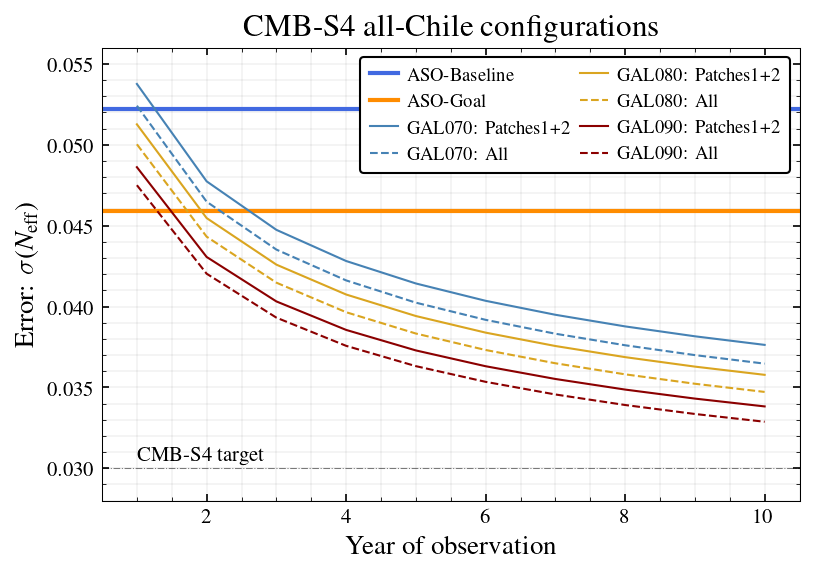

0.052237745760750805
0.04588203776953843


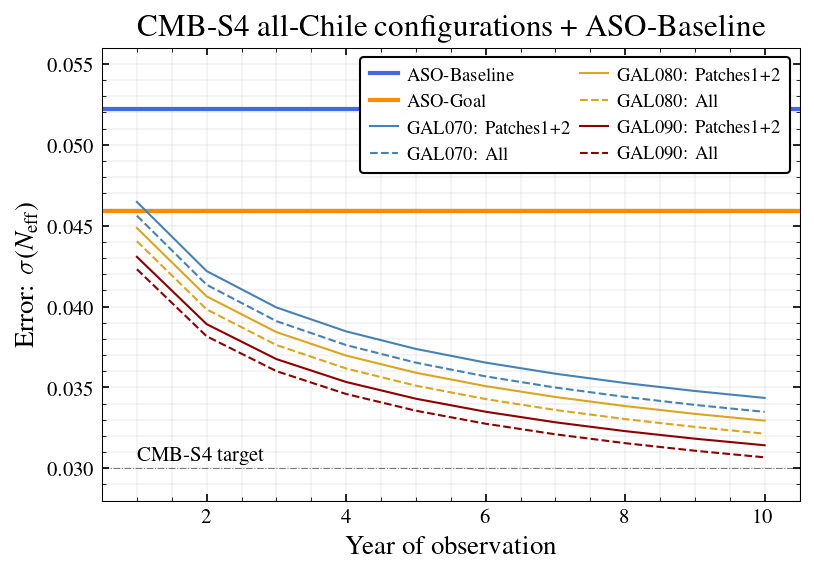

0.052237745760750805
0.04588203776953843


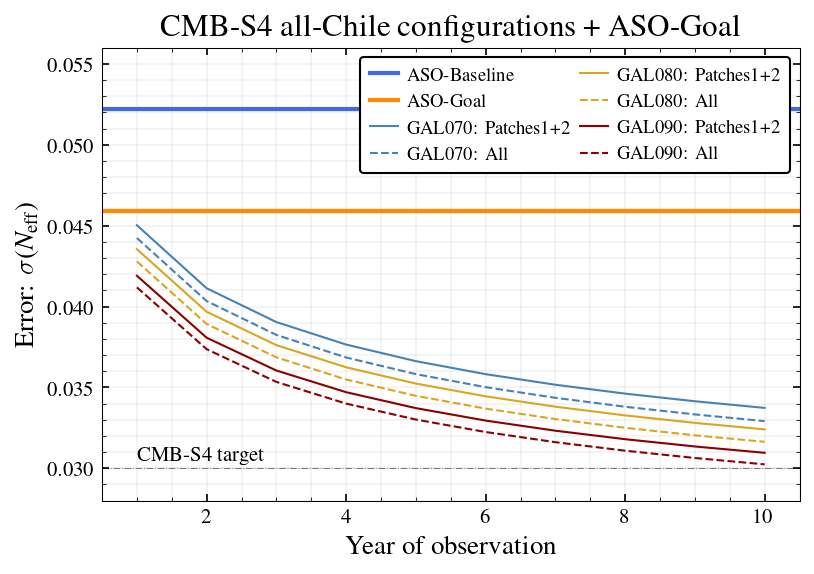

In [23]:
for pliter in range(3):
    if pliter == 0:
        plname = 'plots/sigma_neff_s4_lat_wide.png'
        title_str = r'CMB-S4 all-Chile configurations'
    elif pliter == 1:
        plname = 'plots/sigma_neff_s4_lat_wide_plus_asobaseline.png'
        aso_expname_for_this_iter = 'baseline'
        title_str = r'CMB-S4 all-Chile configurations + ASO-Baseline'
    elif pliter == 2:
        plname = 'plots/sigma_neff_s4_lat_wide_plus_asogoal.png'
        aso_expname_for_this_iter = 'goal'
        title_str = r'CMB-S4 all-Chile configurations + ASO-Goal'
    clf()
    fsval = 13
    ymin, ymax = 0.028, 0.056
    xmin, xmax = 0.5, 10.5
    color_dic = {'GAL070': 'steelblue', 'GAL080': 'goldenrod', 'GAL090': 'darkred'}
    ls_dic = {0: '-', 1: '--'}
    ax = subplot(111)

    #Add ASO-only
    for aso_expname in aso_expname_arr:
        aso_labval, aso_color = aso_exp_dic[aso_expname]
        sigma_neff_curr_aso = sigma_neff_dic_for_aso[aso_expname]
        print(sigma_neff_curr_aso)
        axhline(sigma_neff_curr_aso, lw = 2, alpha = 1., ls = '-', color = aso_color, label = r'%s' %(aso_labval))
    
    if pliter == 0:
        #S4-only
        for reqd_gal_mask in sigma_neff_dic:

            for iter in sigma_neff_dic[reqd_gal_mask]:
                if iter == 0:
                    labval = r'%s: Patches1+2' %(reqd_gal_mask)
                else:
                    labval = r'%s: All' %(reqd_gal_mask)
                sigma_neff_arr = []
                for year in sigma_neff_dic[reqd_gal_mask][iter]:
                    sigma_neff_arr.append( sigma_neff_dic[reqd_gal_mask][iter][year] )
                plot( year_arr, sigma_neff_arr, color = color_dic[reqd_gal_mask], ls = ls_dic[iter], label = labval)
    elif pliter in [1, 2]:
        #S4+ASO-Baseline or S4+ASO-Goal
        for reqd_gal_mask in sigma_neff_dic_for_s4_plus_aso:

            for iter in sigma_neff_dic_for_s4_plus_aso[reqd_gal_mask]:
                if iter == 0:
                    labval = r'%s: Patches1+2' %(reqd_gal_mask)
                else:
                    labval = r'%s: All' %(reqd_gal_mask)
                sigma_neff_arr = []
                for year in sigma_neff_dic_for_s4_plus_aso[reqd_gal_mask][iter][aso_expname_for_this_iter]:
                    sigma_neff_arr.append( sigma_neff_dic_for_s4_plus_aso[reqd_gal_mask][iter][aso_expname_for_this_iter][year] )
                plot( year_arr, sigma_neff_arr, color = color_dic[reqd_gal_mask], ls = ls_dic[iter], label = labval)                    

    axhline(0.03, lw = 0.5, alpha = 0.5, ls = '-.')
    text(1., 0.0305, r'CMB-S4 target')
    ylim( ymin, ymax )
    xlim( xmin, xmax )
    legend(loc = 1, fontsize = fsval-4, ncol = 2, framealpha = 1., columnspacing = 0.5, handletextpad = 0.5, handlelength = 1.5)
    ylabel(r'Error: $\sigma(N_{\rm eff})$', fontsize = fsval)
    xlabel(r'Year of observation', fontsize = fsval )
    title(r'%s' %(title_str), fontsize = fsval + 2)
    grid(True, which = 'both', axis = 'both', lw = 0.2, alpha = 0.2)    
    savefig(plname, dpi = 200.)
    show()

0.374 0.064 0.438
0.598036
0.12
0.052237745760750805
0.04588203776953843
[0.038400297495463066, 0.03454058230150478, 0.03259321224525397, 0.03132021080424517, 0.0303859011690963]


<Figure size 900x600 with 0 Axes>

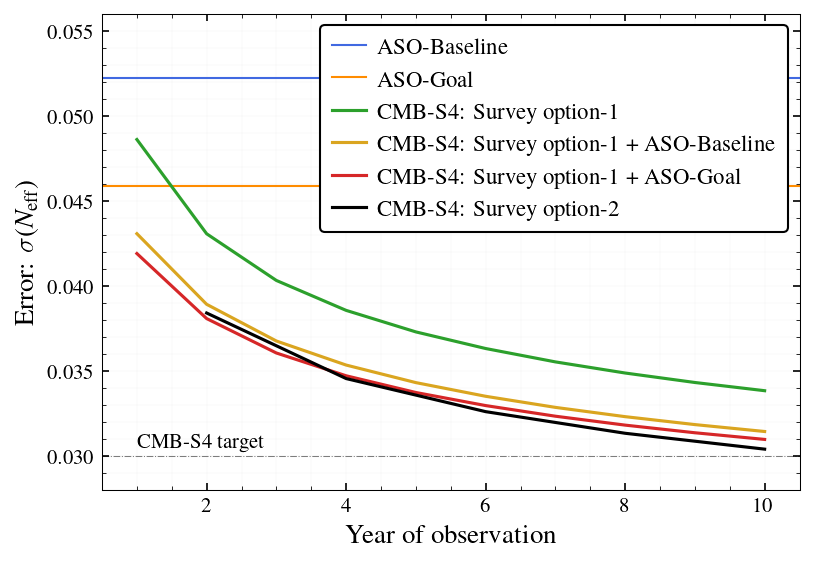

In [24]:
#DC0 and Phase-3
reqd_aso_expname_for_this_iter = 'goal'
reqd_gal_mask = 'GAL090' #'GAL080'
reqd_patch_iter = 0

phase3_colorval = 'tab:green'
phase3_colorval_with_aso_baseline = 'goldenrod'
phase3_colorval_with_aso_goal = 'tab:red' #darkred'
dc0_colorval = 'black'
lwval = 1.5

#fsky
phase3_wide_fsky = fsky_dic[reqd_gal_mask]['wide'][1]  + fsky_dic[reqd_gal_mask]['wide'][2]
phase3_delens_fsky = fsky_dic[reqd_gal_mask]['delensing'][1]  + fsky_dic[reqd_gal_mask]['delensing'][2]
phase3_fsky = phase3_wide_fsky + phase3_delens_fsky
dc0_fsky = dc0_fsky_dic[reqd_gal_mask]['wide'][1]
aso_fsky = fsky_dic_aso['aso_plus_s4']['goal']

print(phase3_wide_fsky, phase3_delens_fsky, phase3_fsky)
print(dc0_fsky)
print(aso_fsky)


clf()
figure(figsize = (6., 4.2))
fsval = 13
ymin, ymax = 0.028, 0.056
xmin, xmax = 0.5, 10.5
color_dic = {'GAL070': 'steelblue', 'GAL080': 'goldenrod', 'GAL090': 'darkred'}
ls_dic = {0: '-', 1: '--'}
ax = subplot(111)

#Add ASO-only
for aso_expname in aso_expname_arr:
    aso_labval, aso_color = aso_exp_dic[aso_expname]
    sigma_neff_curr_aso = sigma_neff_dic_for_aso[aso_expname]
    print(sigma_neff_curr_aso)
    axhline(sigma_neff_curr_aso, lw = 1., alpha = 1., ls = '-', color = aso_color, label = r'%s' %(aso_labval))
    
#Phase-3
sigma_neff_arr = []
for year in sigma_neff_dic[reqd_gal_mask][reqd_patch_iter]:
    sigma_neff_arr.append( sigma_neff_dic[reqd_gal_mask][reqd_patch_iter][year] )
labval = r'CMB-S4: $f_{\rm sky} = %g$' %(phase3_fsky)
labval = r'CMB-S4: Survey option-1'
plot( year_arr, sigma_neff_arr, color = phase3_colorval, ls = '-', lw = lwval, label = labval)

#S4+ASO-Baseline or S4+ASO-Baseline
sigma_neff_arr = []
for year in sigma_neff_dic_for_s4_plus_aso[reqd_gal_mask][reqd_patch_iter]['baseline']:
    sigma_neff_arr.append( sigma_neff_dic_for_s4_plus_aso[reqd_gal_mask][reqd_patch_iter]['baseline'][year] )
#plot( year_arr, sigma_neff_arr, color = phase3_colorval, ls = '-.', lw = lwval, label = r'CMB-S4: Phase3-sims + ASO-Baseline')
labval = r'CMB-S4: $f_{\rm sky} = %g$ + ASO-Baseline: $f_{\rm sky} = %g$' %(phase3_fsky, aso_fsky)
labval = r'CMB-S4: Survey option-1 + ASO-Baseline'
plot( year_arr, sigma_neff_arr, color = phase3_colorval_with_aso_baseline, ls = '-', lw = lwval, label = labval)

#S4+ASO-Baseline or S4+ASO-Goal
sigma_neff_arr = []
for year in sigma_neff_dic_for_s4_plus_aso[reqd_gal_mask][reqd_patch_iter]['goal']:
    sigma_neff_arr.append( sigma_neff_dic_for_s4_plus_aso[reqd_gal_mask][reqd_patch_iter]['goal'][year] )
#plot( year_arr, sigma_neff_arr, color = phase3_colorval, ls = '--', dashes = (5, 1), lw = lwval, label = r'CMB-S4: Phase3-sims + ASO-Goal')
labval = r'CMB-S4: $f_{\rm sky} = %g$ + ASO-Goal: $f_{\rm sky} = %g$' %(phase3_fsky, aso_fsky)
labval = r'CMB-S4: Survey option-1 + ASO-Goal'
plot( year_arr, sigma_neff_arr, color = phase3_colorval_with_aso_goal, ls = '-', lw = lwval, label = labval)

#DC0
sigma_neff_arr = []
year_arr_for_dc0 = []
for year in dc0_sigma_neff_dic[reqd_gal_mask][reqd_patch_iter]:
    if year>5: continue
    sigma_neff_arr.append( dc0_sigma_neff_dic[reqd_gal_mask][reqd_patch_iter][year] )
    year_arr_for_dc0.append( year * 2.)
labval = r'CMB-S4: $f_{\rm sky} = %g$' %(dc0_fsky)
labval = r'CMB-S4: Survey option-2'
plot( year_arr_for_dc0, sigma_neff_arr, color = dc0_colorval, lw = lwval, ls = '-', label = labval)
print( sigma_neff_arr )


#aso_map_level_comb_sigma_neff_val = aso_map_level_comb_sigma_neff_dic[r'DC0 + SO-Goal']
#plot( year_arr_for_dc0[-1], aso_map_level_comb_sigma_neff_val, color = 'black', ls = '-', label = labval)


'''
#S4-DC0+ASO-Baseline
sigma_neff_arr = []
year_arr_for_dc0 = []
for year in dc0_sigma_neff_dic_for_s4_plus_aso[reqd_gal_mask][reqd_patch_iter]['baseline']:
    if year>5: continue
    sigma_neff_arr.append( dc0_sigma_neff_dic_for_s4_plus_aso[reqd_gal_mask][reqd_patch_iter]['baseline'][year] )
    year_arr_for_dc0.append( year * 2.)
plot( year_arr_for_dc0, sigma_neff_arr, color = 'black', ls = '--', label = r'CMB-S4: DC0-sims + ASO-Baseline')

#S4-DC0+ASO-Goal
sigma_neff_arr = []
year_arr_for_dc0 = []
for year in dc0_sigma_neff_dic_for_s4_plus_aso[reqd_gal_mask][reqd_patch_iter]['goal']:
    if year>5: continue
    sigma_neff_arr.append( dc0_sigma_neff_dic_for_s4_plus_aso[reqd_gal_mask][reqd_patch_iter]['goal'][year] )
    year_arr_for_dc0.append( year * 2.)
plot( year_arr_for_dc0, sigma_neff_arr, color = 'black', ls = '-.', label = r'CMB-S4: DC0-sims + ASO-Goal')
'''

axhline(0.03, lw = 0.5, alpha = 0.5, ls = '-.')
text(1., 0.0305, r'CMB-S4 target')
ylim( ymin, ymax )
xlim( xmin, xmax )
legend(loc = 1, fontsize = fsval-2, ncol = 1, framealpha = 1., columnspacing = 0.5, handletextpad = 0.5, handlelength = 1.5)
ylabel(r'Error: $\sigma(N_{\rm eff})$', fontsize = fsval)
xlabel(r'Year of observation', fontsize = fsval )
#title(r'%s' %(title_str), fontsize = fsval + 2)
grid(True, which = 'both', axis = 'both', lw = 0.2, alpha = 0.05)
plname = 'plots/cmbs4_neff_phase3sims_dc0sims_aso.pdf'
savefig(plname, dpi = 200.)
show()

In [33]:
fsky_dic['GAL090'].keys()

dict_keys(['wide', 'dc0', 'delensing'])